# Load data

In [1]:
# import libraries
import numpy as np
import sys
import os

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
hfont = {'family':'sans-serif','fontname':'Helvetica', 'size':20}
mpl.rc('font',family='sans-serif', size=16)

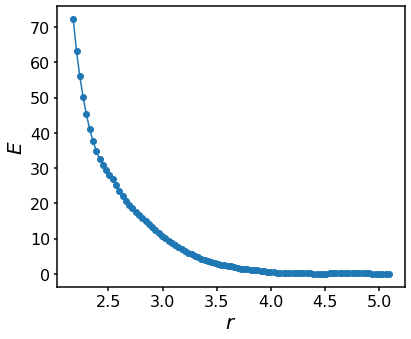

In [2]:
# load data
directory = 'Data2body'
file_name = os.listdir(directory)[0]
file_name = os.path.join(directory, file_name)
file_in = open(file_name, 'r')
lines = file_in.readlines()
file_in.close()
temp = [line.split() for line in lines]
temp = np.array(temp, dtype=np.float64)
r = temp[:,0]
E = temp[:,1]

# remove last (dirty) 3 points
r = r[:-3]
E = E[:-3]

# plot data
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(r, E, '-o')
ax.set_xlabel(r'$r$', **hfont)
ax.set_ylabel(r'$E$', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
fig.tight_layout()
plt.show()

# Build pool of candidates

In [3]:
def fc1(rij, rc):
    f = (rij<rc)*np.tanh(1-rij/rc)**3
    return f

def fc2(rij, rc):
    f = (rij<rc)*0.5*(np.cos(np.pi*rij/rc)+1.0)
    return f

def G2(rij, rc, rs, eta, fc=fc1):
    f = fc(rij, rc)*np.exp(-eta*(rij-rs)**2)
    return f

# build sets of parameters
rc_set = np.array([4.7])
rs_set = np.arange(0, 3.5, 0.5)
eta_set = np.array([0.0, 0.001, 0.01, 0.1, 1, 2, 4, 8, 16])
rc_list = [rc for rc in rc_set for rs in rs_set for eta in eta_set]
rs_list = [rs for rc in rc_set for rs in rs_set for eta in eta_set]
eta_list = [eta for rc in rc_set for rs in rs_set for eta in eta_set]
type_list = [2]*len(rc_list)

# build pool of candidates
Ndata = len(r)
Npool = len(rc_list)
# print(Npool)
pool = np.zeros((Ndata, Npool), dtype=np.float64)
count = 0
for (rc, rs, eta) in zip(rc_list, rs_list, eta_list):
    pool[:,count] = G2(r, rc, rs, eta)
    count += 1
print('Pool of candidates shape: ' + str(pool.shape))
# save dataset
if not os.path.exists('./pool2np'):
    os.mkdir('./pool2np')
save_path = './pool2np/pool.npy'
np.save(save_path, pool)
save_path = './pool2np/target.npy'
np.save(save_path, E)

Pool of candidates shape: (97, 63)


# Select SFs from the pool

In [4]:
# load pool of candidates
path = './pool2np/pool.npy'
pool = np.load(path)
path = './pool2np/target.npy'
E = np.load(path)
print('Pool of candidates shape: ' + str(pool.shape))

Pool of candidates shape: (97, 63)


In [5]:
def select(pool, target, Nmax=None):
    Npool = pool.shape[1]
    Ndata = pool.shape[0]
    if not Nmax or Nmax>Npool:
        Nmax = Npool
        
    std_target = np.std(target, dtype=np.float64, ddof=1)
    r2 = np.zeros(Nmax)
    rmse = np.zeros(Nmax)
    selected_idx = np.zeros(Nmax, dtype=int)
    selected = np.zeros(Npool, dtype=int)
    
    # Step 1: select 1st symmetry function by maximizing correlation
    n = 0
    c2 = np.zeros(Npool) 
    for i in range(Npool):
        corr, p = pearsonr(pool[:,i], target)
        c2[i] = corr*corr
    # select SF with maximum correlation
    selected_idx[n] = np.argmax(c2)
    selected[selected_idx[n]] = 1
    r2[n] = c2[selected_idx[n]]
    rmse[n] = np.sqrt(1-r2[n])*std_target
    print("Ns = %3d,\tSelected index = %3d\tR2 = %.8f\tRMSE = %.8f" % (n+1, selected_idx[n], r2[n], rmse[n]))
    n = 1
    
    # Step 2: select new SFs untill Nmax have been selected
    while(n < Nmax):
        X = np.zeros((Ndata,n+1))
        for k in range(n):
            X[:,k] = pool[:,selected_idx[k]]
        maximum = 0.0
        for i in range(Npool):
            if selected[i] == 0:
                X[:,n] = pool[:,i]
                reg = LinearRegression(fit_intercept=True).fit(X, target)
                corr2 = reg.score(X, target)
                if corr2 > maximum:
                    maximum = corr2
                    selected_idx[n] = i
        r2[n] = maximum
        rmse[n] = np.sqrt(1-r2[n])*std_target
        selected[selected_idx[n]] = 1
        print("Ns = %3d,\tSelected index = %3d\tR2 = %.8f\tRMSE = %.8f" % (n+1, selected_idx[n], r2[n], rmse[n]))
        n += 1
        
    return selected_idx, r2, rmse
        
    
    
# select SFs    
selected_idx, r2, rmse = select(pool, E, Nmax=40)

Ns =   1,	Selected index =  40	R2 = 0.97033692	RMSE = 2.60983346
Ns =   2,	Selected index =  52	R2 = 0.99158645	RMSE = 1.38993458
Ns =   3,	Selected index =   3	R2 = 0.99478066	RMSE = 1.09474386
Ns =   4,	Selected index =  24	R2 = 0.99986020	RMSE = 0.17916847
Ns =   5,	Selected index =  26	R2 = 0.99987593	RMSE = 0.16878576
Ns =   6,	Selected index =  62	R2 = 0.99990105	RMSE = 0.15073302
Ns =   7,	Selected index =  35	R2 = 0.99993633	RMSE = 0.12091461
Ns =   8,	Selected index =  25	R2 = 0.99993656	RMSE = 0.12069502
Ns =   9,	Selected index =  60	R2 = 0.99993819	RMSE = 0.11912888
Ns =  10,	Selected index =  16	R2 = 0.99994423	RMSE = 0.11315910
Ns =  11,	Selected index =  53	R2 = 0.99995485	RMSE = 0.10181455
Ns =  12,	Selected index =  50	R2 = 0.99996534	RMSE = 0.08920838
Ns =  13,	Selected index =  51	R2 = 0.99996843	RMSE = 0.08513667
Ns =  14,	Selected index =  61	R2 = 0.99997166	RMSE = 0.08067090
Ns =  15,	Selected index =  44	R2 = 0.99997543	RMSE = 0.07510754
Ns =  16,	Selected index 

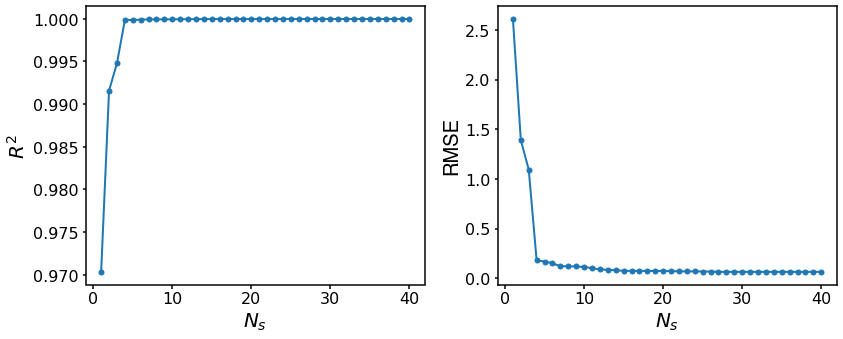

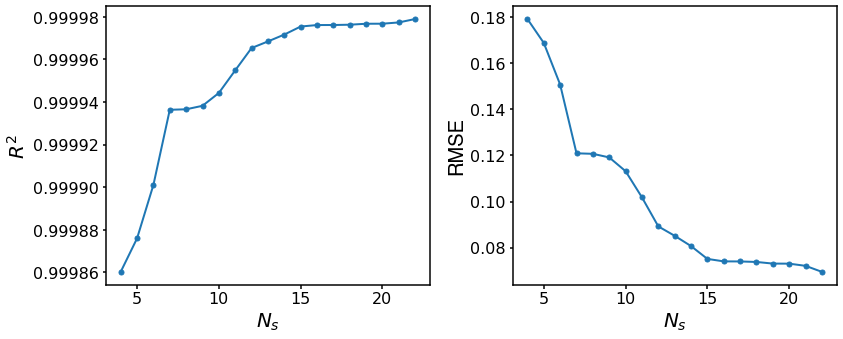

In [6]:
# plot selection results (r2 and rmse as a function of Ns)
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax = axs[0]
ax.plot(np.arange(len(r2)) + 1, r2,'-o', linewidth=2, markersize=5)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
# ax.set_xlim(0, 20)
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'$R^2$', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
ax = axs[1]
ax.plot(np.arange(len(rmse)) + 1, rmse,'-o', linewidth=2, markersize=5)
# ax.xaxis.set_ticks_position('both')
# ax.yaxis.set_ticks_position('both')
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'RMSE', **hfont)
# ax.set_xlim(0, 20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
fig.tight_layout()
# plt.savefig('SFchoice.png', dpi=300, format='png')
plt.show()

# same plot but only in the interesting region
r2_temp = r2[3:22]
rmse_temp = rmse[3:22]
fig, axs = plt.subplots(1, 2, figsize=(12,5))
ax = axs[0]
ax.plot(np.arange(3,22)+1, r2_temp,'-o', linewidth=2, markersize=5)
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'$R^2$', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
ax = axs[1]
ax.plot(np.arange(3,22)+1, rmse_temp,'-o', linewidth=2, markersize=5)
ax.set_xlabel(r'$N_s$', **hfont)
ax.set_ylabel(r'RMSE', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.tick_params(which='major', width=1.5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
fig.tight_layout()
plt.show()

# Result with the chosen number of SFs

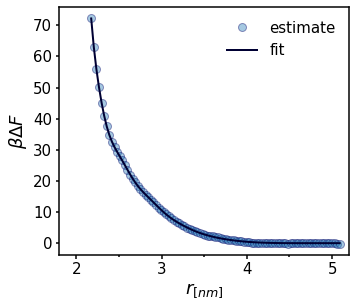

In [7]:
Ns = 12 # chosen number of SFs
X = np.zeros((Ndata,Ns))
for k in range(Ns):
    X[:,k] = pool[:,selected_idx[k]]
reg = LinearRegression(fit_intercept=True).fit(X, E)
Y = reg.predict(X)

hfont = {'family':'sans-serif','fontname':'Helvetica', 'size':18}
mpl.rc('font',family='sans-serif', size=15)
# plot results
fig, ax = plt.subplots(figsize=(5.2,4.5))
color = 0.7*np.array([0.26,0.62,0.65])
# ax.plot(r, E-reg.intercept_,'o', markersize=5)
ax.plot(r, E-reg.intercept_, 'o', mec =[0.,0.,0.4], markersize=8, label='estimate', mew=1, alpha=0.4)
ax.plot(r, Y-reg.intercept_,'-', linewidth=2, color=[0.,0.,0.2], label='fit')
ax.set_xlabel(r'$r_{[nm]}$', **hfont)
ax.set_ylabel(r'$\beta\Delta F$', **hfont)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
ax.tick_params(which='major', width=1.5)
ax.tick_params(which='minor', width=1.5, color='k')
ax.set_xlim(1.8,5.2)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
ax.legend(prop=dict(size=16))
ax.legend(loc="upper right", frameon=False)
fig.tight_layout()
plt.savefig('2body.jpeg', dpi=300, format='jpeg')
plt.show()

In [8]:
# print parameters of the fit and of the selected SFs
for k in range(Ns):
    print("type = %3d,\trc = %.2f\trs = %.2f\teta = %6.3f\tlinear coef = %20.6f" % (type_list[selected_idx[k]], rc_list[selected_idx[k]], rs_list[selected_idx[k]], eta_list[selected_idx[k]], reg.coef_[k]))

type =   2,	rc = 4.70	rs = 2.00	eta =  1.000	linear coef =         -1296.264543
type =   2,	rc = 4.70	rs = 2.50	eta =  8.000	linear coef =         -1170.925458
type =   2,	rc = 4.70	rs = 0.00	eta =  0.100	linear coef =           743.150192
type =   2,	rc = 4.70	rs = 1.00	eta =  4.000	linear coef =        311802.714173
type =   2,	rc = 4.70	rs = 1.00	eta = 16.000	linear coef = -397501182676.691833
type =   2,	rc = 4.70	rs = 3.00	eta = 16.000	linear coef =          -111.527699
type =   2,	rc = 4.70	rs = 1.50	eta = 16.000	linear coef =       3290857.036734
type =   2,	rc = 4.70	rs = 1.00	eta =  8.000	linear coef =    -196875371.577553
type =   2,	rc = 4.70	rs = 3.00	eta =  4.000	linear coef =          -361.034236
type =   2,	rc = 4.70	rs = 0.50	eta =  8.000	linear coef = 1077519327017.677246
type =   2,	rc = 4.70	rs = 2.50	eta = 16.000	linear coef =           490.702354
type =   2,	rc = 4.70	rs = 2.50	eta =  2.000	linear coef =          1731.685558


In [9]:
# save fitting parameters
if not os.path.exists('./fit2np'):
    os.mkdir('./fit2np')
# save_path = './pool2np/pool.npy'
np.save(save_path, pool)
params = np.array([[reg.coef_[k], rc_list[selected_idx[k]], rs_list[selected_idx[k]], eta_list[selected_idx[k]]] for k in range(Ns)])
# print(params)
np.save('./fit2np/params.npy', params)